# Tutorial de Pytorch 5: Clasificador de imágenes

Vamos a realizar un clasificador de imágenes correspondientes a un dataset de 10 clases de objetos. En este caso, las imágenes corresponden a los dígitos del 0 al 9 en lengua de signos. El dataset se puede descargar de la siguiente dirección: https://nbviewer.org/url/cayetanoguerra.github.io/ia/nbpy/data/Sign-Language.zip

#### **Importando las Herramientas Necesarias**
Primero, importamos todas las bibliotecas que vamos a necesitar. Esto incluye torch para todas las cosas relacionadas con deep learning, torchvision para trabajar con imágenes, matplotlib para graficar (por si necesitamos visualizar algo más adelante) y os para interactuar con el sistema operativo.

In [65]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

#### **Configurando el Dispositivo**
Luego, decidimos en qué dispositivo vamos a ejecutar nuestro modelo. Si tienes una GPU disponible, la vamos a aprovechar para acelerar el entrenamiento.

In [66]:
# Configuración del dispositivo (usa GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### P**reparando las Transformaciones de las Imágenes**
Queremos asegurarnos de que todas nuestras imágenes tengan el mismo tamaño y estén en el formato correcto para trabajar con PyTorch. Así que las redimensionamos a 150x150 píxeles, las convertimos a tensores y las normalizamos para que sus valores estén entre 0 y 1.

In [67]:
# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### **Cargando el Conjunto de Datos**
Ahora, cargamos nuestro conjunto de datos de imágenes desde la carpeta 'data/Sign-Language', aplicando las transformaciones que acabamos de definir.

In [68]:
# Cargando el conjunto de datos
dataset = datasets.ImageFolder('data/Sign-Language', transform=transform)

#### **Dividiendo los Datos en Entrenamiento y Test**
Es importante tener un conjunto de datos separado para probar nuestro modelo y asegurarnos de que está aprendiendo correctamente. Así que dividimos nuestro conjunto de datos en un 80% para entrenamiento y un 20% para pruebas.

In [69]:
# Separando los datos en entrenamiento y prueba
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#### **Configurando los Cargadores de Datos**
Para poder alimentar nuestro modelo con los datos, los organizamos en lotes utilizando los DataLoader. Esto nos ayudará a hacer el entrenamiento más eficiente.

In [70]:
# Cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Vamos a mostrar una de las imágenes del dataset para asegurarnos de que todo está funcionando correctamente. Utilizamos matplotlib para mostrar la imagen. Aquí es importante notar que usamos <code>permute(1, 2, 0)</code> para reorganizar los canales de la imagen. PyTorch maneja imágenes con canales al principio (C x H x W), pero matplotlib espera que estén al final (H x W x C), así que hacemos este cambio para que la imagen se muestre correctamente.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  9 (9)


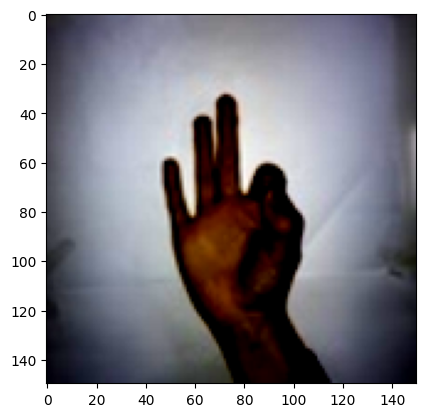

In [71]:
# Muestra una imagen y su etiqueta
def show_img(img, label):
    print('Label: ', dataset.classes[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

# Carga una imagen de prueba
img, label = test_dataset[45]
show_img(img, label)

In [72]:
# Usa el dataloader para cargar un lote de imágenes de prueba
batch = next(iter(test_loader))
print(batch[0].shape, batch[1].shape)

torch.Size([32, 3, 150, 150]) torch.Size([32])


#### **Definiendo la Red Neuronal**
Primero, definimos nuestra red neuronal llamada SimpleCNN. Esta es una clase que hereda de nn.Module, que es la base para todos los módulos de red neuronal en PyTorch. 
Dentro del inicializador __init__, definimos las capas y funciones que vamos a usar:

- Dos capas convolucionales (conv1 y conv2)
- Una capa de pooling (pool)
- Dos capas lineales/densas (fc1 y fc2)
- Una función de activación ReLU (relu)
- Una capa de dropout para reducir el overfitting (dropout)

Luego, implementamos la función forward, que define cómo los datos pasan a través de la red. Aquí, aplicamos las capas convolucionales, la función de activación ReLU, el pooling y finalmente pasamos por las capas lineales.

In [73]:
# Definiendo la red neuronal
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(37 * 37 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 37 * 37 * 64)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#### **Creando el Modelo y Definiendo la Pérdida y el Optimizador**

Aquí, creamos una instancia de nuestra red y la movemos al dispositivo disponible (GPU o CPU).
Definimos la función de pérdida (criterion) como la entropía cruzada, que es comúnmente usada para tareas de clasificación. También elegimos un optimizador (Adadelta en este caso) y le pasamos los parámetros de la red.

In [74]:
model = SimpleCNN()
model = model.to(device)

# Definiendo la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adadelta(model.parameters(), lr=1)

#### **Entrenamiento del Modelo**
Ahora, procedemos a entrenar el modelo. Esto se hace a través de varias épocas, donde en cada época pasamos por todo el conjunto de entrenamiento. En cada paso (batch), actualizamos los pesos de la red para minimizar la función de pérdida.

In [82]:
# Entrenamiento
num_epochs = 10
history = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 1):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {running_loss/10:.4f}')
            history.append(running_loss/10)
            running_loss = 0.0

print('Finished Training')

Epoch 1, Batch 0, Loss: 0.0028
Epoch 1, Batch 10, Loss: 0.1254
Epoch 1, Batch 20, Loss: 0.0992
Epoch 1, Batch 30, Loss: 0.0998
Epoch 1, Batch 40, Loss: 0.1058
Epoch 1, Batch 50, Loss: 0.1101
Epoch 2, Batch 0, Loss: 0.0194
Epoch 2, Batch 10, Loss: 0.1123
Epoch 2, Batch 20, Loss: 0.1120
Epoch 2, Batch 30, Loss: 0.0727
Epoch 2, Batch 40, Loss: 0.0814
Epoch 2, Batch 50, Loss: 0.0697
Epoch 3, Batch 0, Loss: 0.0067
Epoch 3, Batch 10, Loss: 0.0628
Epoch 3, Batch 20, Loss: 0.0915
Epoch 3, Batch 30, Loss: 0.0352
Epoch 3, Batch 40, Loss: 0.0544
Epoch 3, Batch 50, Loss: 0.1053
Epoch 4, Batch 0, Loss: 0.0078
Epoch 4, Batch 10, Loss: 0.0481
Epoch 4, Batch 20, Loss: 0.0740
Epoch 4, Batch 30, Loss: 0.0822
Epoch 4, Batch 40, Loss: 0.1019
Epoch 4, Batch 50, Loss: 0.0787
Epoch 5, Batch 0, Loss: 0.0009
Epoch 5, Batch 10, Loss: 0.0596
Epoch 5, Batch 20, Loss: 0.0438
Epoch 5, Batch 30, Loss: 0.0725
Epoch 5, Batch 40, Loss: 0.1283
Epoch 5, Batch 50, Loss: 0.0766
Epoch 6, Batch 0, Loss: 0.0013
Epoch 6, Batch

#### **Gráfica de la Pérdida**
Graficamos la pérdida a través de las épocas para ver cómo se comporta nuestro modelo. Como podemos ver, la pérdida disminuye a medida que el modelo aprende.

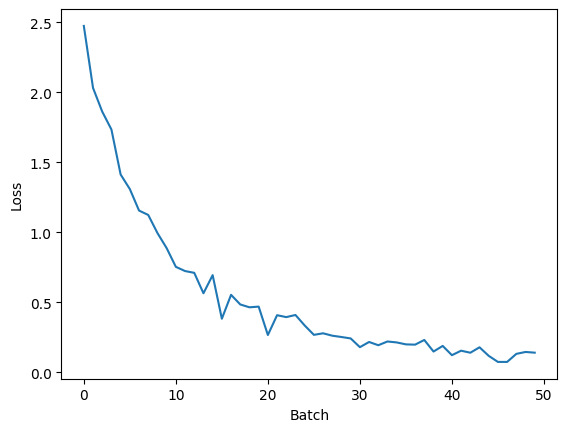

In [77]:
# Plot loss
plt.plot(history)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

#### **Evaluación del Modelo**
Finalmente, evaluamos el rendimiento del modelo en el conjunto de prueba. Aquí, calculamos el número de predicciones correctas y lo utilizamos para calcular la precisión del modelo, la cual se imprime al final.

In [76]:

# Evaluación
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test images: {100 * correct / total:.2f}%')


Accuracy on test images: 83.29%


#### **Matriz de Confusión**

Para tener una mejor idea de cómo se comporta nuestro modelo, podemos graficar la matriz de confusión. Esto nos muestra cuántas veces el modelo predijo correctamente cada clase, y cuántas veces se confundió. El eje x representa las predicciones del modelo, y el eje y representa las etiquetas reales.

In [78]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))



Confusion Matrix
[[36  2  0  0  0  0  0  0  1  1]
 [ 3 29  3  1  0  0  0  0  0  0]
 [ 1  4 38  0  0  0  2  1  0  0]
 [ 0  1  0 42  0  1  1  0  0  1]
 [ 0  1  0  0 38  0  4  2  0  2]
 [ 0  0  0  0  2 41  0  0  0  0]
 [ 0  0  5  1  3  0 27  1  0  0]
 [ 2  1  9  0  3  1  1 17  4  0]
 [ 1  0  0  0  0  0  0  1 32  2]
 [ 1  0  0  0  0  4  0  0  0 39]]


#### **Métricas de Evaluación**

También podemos calcular otras métricas de evaluación, como la precisión, la sensibilidad y la f1-score. Estas métricas nos dan una mejor idea de cómo se comporta el modelo para cada clase.

In [79]:
# Metricas
print('Classification Report')
print(metrics.classification_report(y_true, y_pred, target_names=dataset.classes))

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        40
           1       0.76      0.81      0.78        36
           2       0.69      0.83      0.75        46
           3       0.95      0.91      0.93        46
           4       0.83      0.81      0.82        47
           5       0.87      0.95      0.91        43
           6       0.77      0.73      0.75        37
           7       0.77      0.45      0.57        38
           8       0.86      0.89      0.88        36
           9       0.87      0.89      0.88        44

    accuracy                           0.82       413
   macro avg       0.82      0.82      0.81       413
weighted avg       0.82      0.82      0.82       413



In [81]:
# Guardando el modelo completo
torch.save(model, 'sign_language_model.pth')

### Ejercicios

1. Comprueba cómo se comporta el modelo con las imágenes de entrenamiento. ¿Qué tan bien funciona?
2. Cambia los parámetros de la red, como el número de filtros, el tamaño del kernel, el tamaño del batch, etc. ¿Cómo afecta esto al rendimiento del modelo?